In [1]:
#Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier

import pickle
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from joblib import dump, load
from imblearn.pipeline import Pipeline as imbPipeline
import seaborn as sns
%matplotlib inline
import string
import sklearn
from sklearn.neural_network import MLPRegressor

In [2]:
import os
os.getcwd()

'C:\\Users\\sanyu'

In [3]:
#Importing the scraped dataset that already have a category assigned to them in Craigslist
df = pd.read_csv("C:/Users/sanyu/Downloads/Merged_excel_v2.csv", index_col=0)
df=df.reset_index()


In [4]:
#Performing Exploratory Data Analysis
#Get value count of each category
print(df.SubCategory.value_counts())

general             1846
cars+trucks         1133
beauty+hlth          558
auto parts           420
appliances           386
arts+crafts          363
antiques             351
atv/utv/sno          337
baby+kid             333
boat parts           227
boats                225
barter               222
bikes                219
trailers             212
sporting             211
bike parts           208
farm+garden          207
books                203
furniture            202
business             201
music instr          198
household            194
toys+games           192
materials            192
wheels+tires         191
collectibles         191
heavy equip          190
wanted               190
tools                189
electronics          185
cds/dvd/vhs          181
jewelry              180
clothes+acc          179
motorcycle parts     178
aviation             177
computers            172
free                 169
computer parts       165
video gaming         156
photo+video          150


Text(0.5, 1.0, 'Number of subcategories')

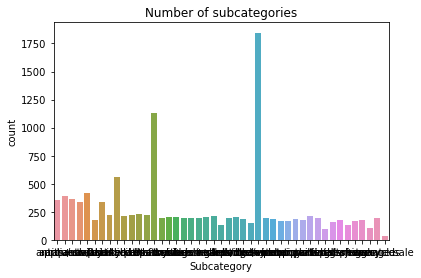

In [5]:
#Creating a plot to see all Subcategory distribution
sns.countplot(x='SubCategory',data=df)
plt.xlabel('Subcategory')
plt.title('Number of subcategories')

In [6]:
# Keep Target Categories that we will use in the predicton of our prediction dataset
#Remove categories like general, barter, free and wanted
target_categories = ['cars+trucks', 'beauty+hlth']
remove_categories = ['general', 'barter', 'free', 'wanted']
df = df[~df['SubCategory'].isin(remove_categories)]

In [7]:
#Create a new data frame that has only 3 categories- cars+trucks, beauty+hlth, Others
df_target = df[df['SubCategory'].isin(target_categories)]
df_others = df.drop(df_target.index)
df_others['SubCategory']='Others'
df_others = df_others.sample(frac=1, random_state = 0)
df_new = pd.concat([df_target,df_others])
df_new['Title + Body'] = df_new['Title']+df_new['Body']


Text(0.5, 0, 'Length description')

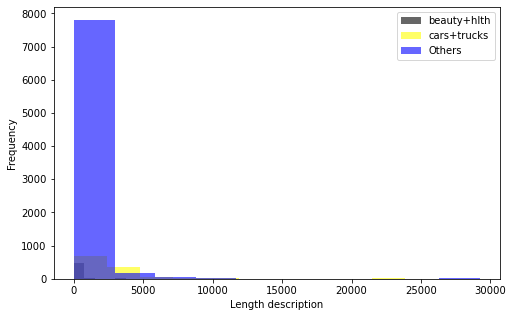

In [8]:
#More Exploratory Data analysis on new dataframe with only 3 categories
plt.figure(figsize=(8, 5))
df_new['length'] = df_new['Body'].str.len()
df_new[df_new.SubCategory == 'beauty+hlth'].length.plot(bins=35, kind='hist', color='black', label='beauty+hlth', alpha=0.6)
df_new[df_new.SubCategory == 'cars+trucks'].length.plot(kind='hist', color='yellow', label='cars+trucks', alpha=0.6)
df_new[df_new.SubCategory == 'Others'].length.plot(kind='hist', color='blue', label='Others', alpha=0.6)
plt.legend()
plt.xlabel("Length description")

array([[<AxesSubplot:title={'center':'Others'}>,
        <AxesSubplot:title={'center':'beauty+hlth'}>],
       [<AxesSubplot:title={'center':'cars+trucks'}>, <AxesSubplot:>]],
      dtype=object)

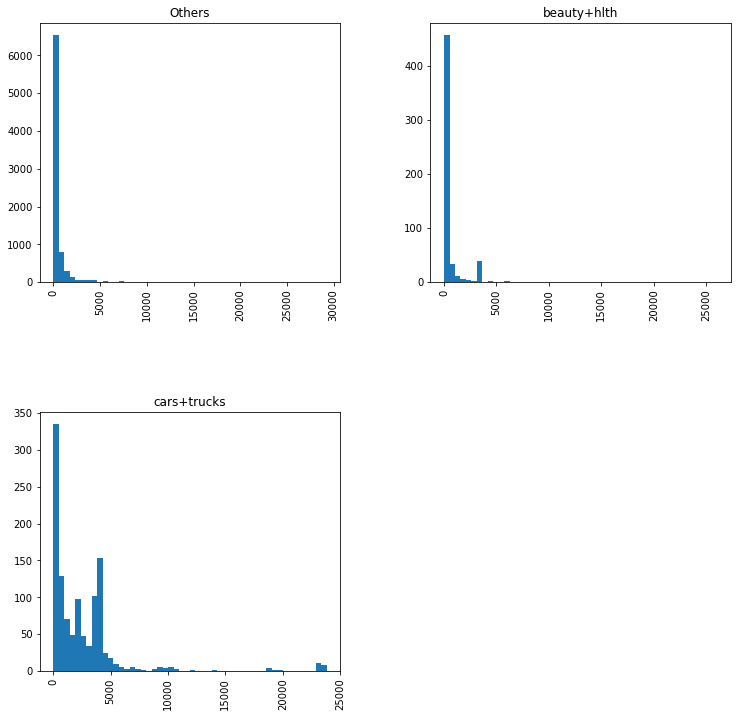

In [9]:
#More lengthy description for cars compared to other categories
df_new.hist(column='length', by='SubCategory', bins=50,figsize=(12,12))

In [10]:
#Creating a stop variable for removing stop words
stop = stopwords.words('english')

#Creating an object for lemmatization and stemming
lemmatizer = nltk.stem.WordNetLemmatizer()
porter = PorterStemmer()

In [11]:
stop=stopwords.words('english')
def preprocess_data(text):
    ''' The function to remove punctuation,
    stopwords and apply stemming'''

    words = re.sub("[^a-zA-Z]", " ", text)
    words = [word.lower() for word in text.split() if word.lower() not in stop]
    #words = [porter.stem(word) for word in words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(words)

In [12]:
df_new['Title + Body'] = df_new['Title + Body'].astype(str).apply(preprocess_data).dropna()
df_new['Title + Body']

429     chaga mushroom - tincture & ground (for tea)fr...
430     save money high quality- pre owned medical equ...
431     u need medical equipment? save u money! -shipp...
432     jazzy selecet elite power chair [2 available]r...
433     clenbuterol peptide salebuy clenbuterol online...
                              ...                        
8627    l. e. morrison bee hive trunk factory steamer ...
5036    victory pool cue case baga victory pool cue ca...
3160    shimano sram cassettesall part excellent condi...
4281    2023 kz connect se c261bhse bunkhouse - 30 ft ...
4426    harley davidson 1997 roadking custom show bike...
Name: Title + Body, Length: 9758, dtype: object

In [13]:
print(df_new)

      SubCategory                                              Title  \
429   beauty+hlth       Chaga Mushroom - Tincture & Ground (for tea)   
430   beauty+hlth  Save Money on High Quality- Pre Owned Medical ...   
431   beauty+hlth  Do U Need Medical Equipment?  We Can Save U Mo...   
432   beauty+hlth      Jazzy Selecet Elite Power Chair [2 available]   
433   beauty+hlth                       Clenbuterol Peptide for Sale   
...           ...                                                ...   
8627       Others  L. E. Morrison Bee Hive Trunk Factory Steamer ...   
5036       Others                     VICTORY Pool cue with case bag   
3160       Others                         Shimano and SRAM cassettes   
4281       Others  2023 KZ Connect SE C261BHSE Bunkhouse - 30 Ft ...   
4426       Others  HARLEY DAVIDSON 1997 RoadKing CUSTOM Show Bike...   

                                                   Body  \
429   Fresh Chaga mushroom - harvested sustainably a...   
430   Do You Want

In [14]:
#Creating a count vectorizer object and fitting it into the Title+Body 
vectorizer = CountVectorizer()
vectorizer.fit(df_new['Title + Body'])
vector = vectorizer.transform(df_new['Title + Body'])

In [15]:
#Creating a tfidf vectorizer and performing fit_transform to the vectorized data
tfidf_converter = TfidfTransformer()
X_tfidf = tfidf_converter.fit_transform(vector).toarray()
print(X_tfidf)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.06901367, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04727938, 0.0550964 , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [16]:
#Splitting the dataset into train and test 
X = df_new['Title + Body']
y = df_new['SubCategory']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [17]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7318,) (2440,) (7318,) (2440,)


In [18]:
dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Linear SVC": LinearSVC(),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=50),
    "Random Forest": RandomForestClassifier(n_estimators=20),
    "Naive bayes": MultinomialNB(),
    'SVC ovr': LinearSVC(multi_class='ovr'),
    'Logistic Regression Multinomial':LogisticRegression(multi_class='multinomial', max_iter=200),
    
}

In [19]:
# Loop to iterate through all classifiers using a pipeline
for i in dict_classifiers:
    model_log = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
                      ('tfidf', TfidfTransformer()),
                      ('model',dict_classifiers[i])
                     ])
    model_log.fit(X_train, y_train)

    ytest = np.array(y_test)
    pred = model_log.predict(X_test)
    print('The accuracy of', i, 'is %s' % accuracy_score(pred, y_test))
    print(classification_report(ytest, pred))

The accuracy of Logistic Regression is 0.9307377049180328
              precision    recall  f1-score   support

      Others       0.92      1.00      0.96      1998
 beauty+hlth       0.95      0.24      0.38       157
 cars+trucks       1.00      0.84      0.91       285

    accuracy                           0.93      2440
   macro avg       0.96      0.69      0.75      2440
weighted avg       0.93      0.93      0.92      2440

The accuracy of Linear SVC is 0.953688524590164
              precision    recall  f1-score   support

      Others       0.95      0.99      0.97      1998
 beauty+hlth       0.94      0.51      0.66       157
 cars+trucks       0.97      0.92      0.94       285

    accuracy                           0.95      2440
   macro avg       0.96      0.81      0.86      2440
weighted avg       0.95      0.95      0.95      2440

The accuracy of Gradient Boosting is 0.9229508196721311
              precision    recall  f1-score   support

      Others       0.

In [20]:
#Loop through all classifiers using SMOTE with the help of imbPipeline
for j in dict_classifiers:
    model_log = imbPipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
                      ('tfidf', TfidfTransformer()),
                         ('oversample', SMOTE(random_state=5)),
    ('model',dict_classifiers[j])
                     ])

    model_log.fit(X_train, y_train)
    ytest = np.array(y_test)
    pred = model_log.predict(X_test)
    print('The accuracy of', j, 'is %s' % accuracy_score(pred, y_test))
    print(classification_report(ytest, pred))
    

The accuracy of Logistic Regression is 0.9512295081967214
              precision    recall  f1-score   support

      Others       0.96      0.98      0.97      1998
 beauty+hlth       0.79      0.65      0.71       157
 cars+trucks       0.95      0.92      0.93       285

    accuracy                           0.95      2440
   macro avg       0.90      0.85      0.87      2440
weighted avg       0.95      0.95      0.95      2440

The accuracy of Linear SVC is 0.955327868852459
              precision    recall  f1-score   support

      Others       0.96      0.98      0.97      1998
 beauty+hlth       0.82      0.63      0.71       157
 cars+trucks       0.97      0.93      0.95       285

    accuracy                           0.96      2440
   macro avg       0.92      0.85      0.88      2440
weighted avg       0.95      0.96      0.95      2440

The accuracy of Gradient Boosting is 0.9184426229508197
              precision    recall  f1-score   support

      Others       0.

In [21]:
#Import the prediction dataset which has been pulled from general category
sample = pd.read_csv('C:/Users/sanyu/Downloads/Predicted_general_SP.csv', index_col=0)
x_sample = sample['Title + Body']
y_sample_actual = sample['Actual']
sample.drop(columns=['SubCategory','Tags','City','Predicted'],inplace=True)
print(sample)

                                                 Title  \
0                         Commercial/Business LED Sign   
1             6 ft. Werner ladder with 250 lb capacity   
2                 20" handmade  michigan cedar wreaths   
3                 Seasoned maple firewood - burns hot!   
4                        Mini Bike - Trailmaster MB200   
...                                                ...   
1841                                  Barn/ house sale   
1842  Ralph Lauren reversible comforter with bed skirt   
1843                            4 plastic wine glasses   
1844    Wood Cleaner & Stain/Paint Stripper, 6 bottles   
1845                             Metal fish decoration   

                                                   Body  \
0     This is a double-face cabinet sign with a blac...   
1     A+aluminum 6 foot ladder with fiberglass top a...   
2     These wreaths are beautiful.  Many bow styles ...   
3     This is a longer stack of seasoned maple firew...   
4     Th

In [22]:
#As SVC with SMOTE has the best test accuracy
svc_smote = imbPipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()), ('oversample', SMOTE()),
                ('model', LinearSVC(multi_class='ovr')),
                ])

svc_smote.fit(X_train, y_train)

ytest = np.array(y_test)
y_pred = svc_smote.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(ytest, y_pred))
y_sample = svc_smote.predict(x_sample)
y_sample_df = pd.DataFrame(y_sample).reset_index()
sample = pd.concat([sample, y_sample_df], axis=1)

accuracy 0.9561475409836065
              precision    recall  f1-score   support

      Others       0.96      0.98      0.97      1998
 beauty+hlth       0.82      0.63      0.71       157
 cars+trucks       0.97      0.93      0.95       285

    accuracy                           0.96      2440
   macro avg       0.92      0.85      0.88      2440
weighted avg       0.95      0.96      0.95      2440



In [23]:
print(sample)

                                                 Title  \
0                         Commercial/Business LED Sign   
1             6 ft. Werner ladder with 250 lb capacity   
2                 20" handmade  michigan cedar wreaths   
3                 Seasoned maple firewood - burns hot!   
4                        Mini Bike - Trailmaster MB200   
...                                                ...   
1841                                  Barn/ house sale   
1842  Ralph Lauren reversible comforter with bed skirt   
1843                            4 plastic wine glasses   
1844    Wood Cleaner & Stain/Paint Stripper, 6 bottles   
1845                             Metal fish decoration   

                                                   Body  \
0     This is a double-face cabinet sign with a blac...   
1     A+aluminum 6 foot ladder with fiberglass top a...   
2     These wreaths are beautiful.  Many bow styles ...   
3     This is a longer stack of seasoned maple firew...   
4     Th

In [24]:
sample.drop('index', axis=1, inplace=True)

In [25]:
sample.rename(columns={0: 'Predicted Cat'}, inplace=True)
sample.to_excel('Predicted_data.xlsx')

C:\Users\sanyu\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:941: UserWarning: Ignoring URL 'https://yoursteelstorage.com/CLAt%20Your%20Steel%20Storage,%20we%20have%20New%20and%20Used%20containers,%20all%20guaranteed%20to%20be%20100%25%20wind%20and%20water%20tight,%20with%20no%20leaks%20or%20holes.%20There%20is%20no%20major%20structural%20damage,%20the%20doors%20and%20seals%20function%20properly,%20and%20the%20flooring%20is%20in%20good%20condition.We%20source%20containers%20from%20shipping%20yards%20near%20you,%20which%20saves%20you%20money%20on%20delivery%20costs%20and%20gets%20them%20to%20you%20FAST%20(within%207%20business%20days).%20It%20also%20keeps%20business%20close%20to%20home%20and%20provides%20LOCAL%20AREA%20SERVICE.Contact%20us%20TODAY%20with%20your%20delivery%20zip%20code%20for%20a%20FREE,%20easy,%20no%20hassle%20direct%20quote.877-977-1987Or%20Visit%20us%20at%20for%20an%20instant%20quote%20https://yoursteelstorage.com/CLDELIVERY%20TO%20RESIDENTIAL%20OR%20COMMERCIAL%2

In [26]:
#------------Topic modeling for general data set-------------------------

In [27]:
df_general = pd.read_csv('C:/Users/sanyu/Downloads/Predicted_general_SP.csv', index_col=0)

list_of_words = []
final_list_of_words = []

In [28]:
df_general=df_general.rename(columns={"Title + Body":"final"})

In [29]:
df_general=df_general.drop_duplicates(subset=['final'])

In [30]:
df_general['final']=df_general['final'].astype('str')

In [31]:
#Manually removed words which add no meaning to the corpus
s= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't","new","text","contact","great","condition","used","sale","price","x",\
            "u","please","http","info","good","ta","show","one","need","cash","call"]

In [32]:
from nltk.corpus import stopwords
punctuation_removal=set(string.punctuation)
lemmatizer = nltk.stem.WordNetLemmatizer()
corpus=[]
for i in df_general['final']:
    tokenized_words = nltk.word_tokenize(i)
    tokenized_words_low = [word.lower() for word in tokenized_words]
    clean_words=[word for word in tokenized_words_low if not word in stopwords.words('english')
                 if not word in punctuation_removal if not word in s]
    clean_words2=[word for word in clean_words if word.isalpha() if not word in s]
    lemmatized_list = [lemmatizer.lemmatize(word) for word in clean_words2]
    lemmatized_list = ' '.join(lemmatized_list)
    corpus.append(lemmatized_list)

In [33]:
l=[]

for i in corpus:
    c=i.split()
    for j in c:
        l.append(j)

In [34]:
from nltk.probability import FreqDist
fdist = FreqDist(l)
top_words = fdist.most_common(100)

In [35]:
top_words

[('container', 3514),
 ('storag', 2194),
 ('storage', 1371),
 ('ship', 1235),
 ('contain', 1168),
 ('steel', 1000),
 ('box', 937),
 ('metal', 901),
 ('cargo', 817),
 ('shed', 705),
 ('use', 670),
 ('portabl', 664),
 ('door', 589),
 ('build', 589),
 ('carport', 528),
 ('building', 487),
 ('conex', 481),
 ('home', 427),
 ('cover', 416),
 ('barn', 411),
 ('roof', 384),
 ('trailer', 382),
 ('foot', 355),
 ('u', 351),
 ('custom', 345),
 ('size', 344),
 ('high', 343),
 ('free', 339),
 ('shop', 328),
 ('offer', 295),
 ('wide', 295),
 ('tool', 286),
 ('year', 285),
 ('ocean', 274),
 ('work', 273),
 ('also', 268),
 ('includ', 268),
 ('water', 268),
 ('car', 261),
 ('mobil', 255),
 ('mini', 249),
 ('plea', 245),
 ('sea', 243),
 ('sell', 236),
 ('long', 235),
 ('avail', 229),
 ('light', 228),
 ('vertic', 228),
 ('shelter', 224),
 ('deliveri', 223),
 ('garage', 219),
 ('farm', 218),
 ('time', 216),
 ('connex', 214),
 ('unit', 210),
 ('color', 209),
 ('style', 203),
 ('roll', 201),
 ('pod', 199),
 

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer1 = CountVectorizer(ngram_range=(1, 2), min_df=5, stop_words=s)
vectorizer1.fit(corpus)
print(vectorizer1.vocabulary_)
v1 = vectorizer1.transform(corpus)
print(v1.toarray())
terms = vectorizer1.get_feature_names()
vectorized = vectorizer1.fit_transform(corpus)

{'led': 2699, 'cabinet': 643, 'sign': 4326, 'black': 395, 'aluminum': 87, 'frame': 1935, 'acryl': 21, 'face': 1741, 'intern': 2513, 'manufactur': 2955, 'made': 2907, 'previous': 3688, 'use': 5117, 'church': 869, 'current': 1252, 'sold': 4411, 'condit': 991, 'complet': 969, 'origin': 3393, 'unit': 5086, 'doubl': 1506, 'sinc': 4335, 'excel': 1701, 'fair': 1755, 'consid': 1028, 'qualiti': 3771, 'versatil': 5189, 'commerci': 951, 'best': 376, 'offer': 3290, 'seriou': 4182, 'buyer': 627, 'note': 3260, 'pickup': 3538, 'best offer': 379, 'ladder': 2626, 'lb': 2670, 'foot': 1901, 'top': 4927, 'paint': 3434, 'shelf': 4251, 'rate': 3829, 'pound': 3663, 'picture': 3543, 'blue': 408, 'tray': 4999, 'rest': 3928, 'super': 4755, 'defect': 1346, 'live': 2790, 'except': 1703, 'also': 72, 'look': 2861, 'home': 2297, 'owner': 3417, 'excel condit': 1702, 'home owner': 2313, 'handmad': 2193, 'cedar': 779, 'mani': 2944, 'bow': 448, 'style': 4725, 'choos': 858, 'may': 3003, 'bulk': 598, 'discount': 1450, 'se

C:\Users\sanyu\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [37]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=2)
                                                                              
x_topics = lda.fit_transform(v1)

In [38]:
doc_topic = lda.transform(v1)

In [39]:
for n in range(doc_topic.shape[0]):
    
    topic_doc = doc_topic[n].argmax()

    
    print("Document", n + 1, " -- Topic:", topic_doc)

Document 1  -- Topic: 0
Document 2  -- Topic: 0
Document 3  -- Topic: 0
Document 4  -- Topic: 0
Document 5  -- Topic: 0
Document 6  -- Topic: 0
Document 7  -- Topic: 0
Document 8  -- Topic: 0
Document 9  -- Topic: 0
Document 10  -- Topic: 0
Document 11  -- Topic: 0
Document 12  -- Topic: 0
Document 13  -- Topic: 0
Document 14  -- Topic: 0
Document 15  -- Topic: 0
Document 16  -- Topic: 0
Document 17  -- Topic: 0
Document 18  -- Topic: 0
Document 19  -- Topic: 0
Document 20  -- Topic: 0
Document 21  -- Topic: 0
Document 22  -- Topic: 0
Document 23  -- Topic: 0
Document 24  -- Topic: 0
Document 25  -- Topic: 0
Document 26  -- Topic: 0
Document 27  -- Topic: 0
Document 28  -- Topic: 0
Document 29  -- Topic: 0
Document 30  -- Topic: 0
Document 31  -- Topic: 0
Document 32  -- Topic: 0
Document 33  -- Topic: 0
Document 34  -- Topic: 0
Document 35  -- Topic: 0
Document 36  -- Topic: 0
Document 37  -- Topic: 0
Document 38  -- Topic: 0
Document 39  -- Topic: 0
Document 40  -- Topic: 0
Document 

In [40]:
for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx))
    print(" ".join([terms[i] for i in topic.argsort()[:-5 - 1:-1]]))

Topic 0:
metal use build size home
Topic 1:
container storag storage contain ship


In [41]:
import pyLDAvis
import pyLDAvis.sklearn

In [42]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, vectorized,vectorizer1 ,mds='tsne')

C:\Users\sanyu\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
